In [1]:
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import wandb
from collections import deque
from src.utils.util import ShellColor as sc

print(f"{sc.COLOR_PURPLE}Gym version:{sc.ENDC} {gym.__version__}")
print(f"{sc.COLOR_PURPLE}Pytorch version:{sc.ENDC} {torch.__version__}")

from src.agents.dqn_agent import DQNAgent
from src.utils import util as rl_util
from src.envs.atari2 import *

Gym version: 0.27.0
Pytorch version: 1.12.0+cu113


In [2]:
env_name = "PongNoFrameskip-v4"
env = gym.make(env_name)
env = gym.wrappers.AtariPreprocessing(
    env=env, 
    terminal_on_life_loss=True, 
    grayscale_obs=True, 
    scale_obs=False,
    noop_max=0)
# env = ImageToPyTorch(env)
env = gym.wrappers.FrameStack(env, num_stack=4)
rl_util.print_env_info(env=env)

============ Env Info ===========
Env id: PongNoFrameskip-v4
Observation space size: (4, 84, 84)
Action space size: 6
Action list: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


In [3]:
state, info = env.reset()
state.shape

(4, 84, 84)

In [4]:
config = rl_util.create_config()
config["seed"]=42
wandb.init(project="DDQN-Atari", config=config)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wlseowhd12 (cau-railab). Use `wandb login --relogin` to force relogin
/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [5]:
# wandb.init(project="DQN-cartpole", config=config)

In [6]:
agent = DQNAgent(
    obs_space_shape=env.observation_space.shape,
    action_space_dims=env.action_space.n,
    is_atari=True,
    config=config,
    use_double_dqn=True
)

print(agent.config)
print(type(agent.memory))

Model Initializing... An input shape is (4, 84, 84)
Model Initializing... An input shape is (4, 84, 84)
Double DQN Agent
========== Config Info ==========
env: PongNoFrameskip-v4
num_steps: 1000000
batch_size: 32
gamma: 0.99
lr: 0.0001
learning_starts: 10000
learning_frequency: 1
epsilon_start: 1
epsilon_end: 0.01
epsilon_decay: 100000
seed: 42
target_update_frequency: 1000
buffer_type: uniform
buffer_size: 5000
device: cuda:0
mean_reward_bound: 10
print_frequency: 10
<class 'src.commons.memory.replay_memory.ReplayMemory'>


In [7]:
save_dir = "result/DDQN/atari/"
rl_util.create_directory(save_dir)
save_model_name = save_dir + env_name + "_mean_score.pt"

In [8]:
state, _ = env.reset()
episode_rewards = [0.0]
best_mean_reward = -10000
for t in range(agent.config.num_steps):
    fraction = min(1.0, float(t) / agent.config.epsilon_decay)
    eps_threshold = agent.config.epsilon_start + fraction * \
        (agent.config.epsilon_end - agent.config.epsilon_start)
    # sample = random.random()
    action = agent.select_action(state, eps_threshold)
    next_state, reward, done, _, info = env.step(action)
    agent.store_transition(state, action, reward, next_state, float(done))
    state = next_state

    episode_rewards[-1] += reward
    if done:
        state, _ = env.reset()
        episode_rewards.append(0.0)

    if t > agent.config.learning_starts and t % agent.config.learning_frequency == 0:
        agent.update()

    if t > agent.config.learning_starts and t % agent.config.target_update_frequency == 0:
        agent.update_target_network()

    num_episodes = len(episode_rewards)

    if done and agent.config.print_frequency is not None and len(episode_rewards) % agent.config.print_frequency == 0:
        mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
        print("********************************************************")
        print("steps: {}".format(t))
        print("episodes: {}".format(num_episodes))
        print("mean 100 episode reward: {}".format(mean_100ep_reward))
        print("% epsilon: {}".format(eps_threshold))
        print("********************************************************")
        wandb.log({
            "episode": num_episodes,
            "mean reward": mean_100ep_reward,
            "epsilon": eps_threshold
        })
        if best_mean_reward < mean_100ep_reward:
            torch.save(agent.policy_network.state_dict(), save_model_name)
            print(f"Best mean reward updated {best_mean_reward:.3f} -> {mean_100ep_reward:.3f}, model saved")
            best_mean_reward = mean_100ep_reward
            if mean_100ep_reward > agent.config.mean_reward_bound:
                print(f"Solved!")
                break
            else:
                if num_episodes > 1000:
                    break

********************************************************
steps: 8323
episodes: 10
mean 100 episode reward: -20.3
% time spent exploring: 91
********************************************************
Best mean reward updated -10000.000 -> -20.300, model saved
********************************************************
steps: 17695
episodes: 20
mean 100 episode reward: -20.5
% time spent exploring: 82
********************************************************
********************************************************
steps: 26917
episodes: 30
mean 100 episode reward: -20.4
% time spent exploring: 73
********************************************************
********************************************************
steps: 35899
episodes: 40
mean 100 episode reward: -20.4
% time spent exploring: 64
********************************************************
********************************************************
steps: 44562
episodes: 50
mean 100 episode reward: -20.4
% time spent exploring: 55
********

Save result/DDQN/atari/reward_2023_02_12_05_07_31.png


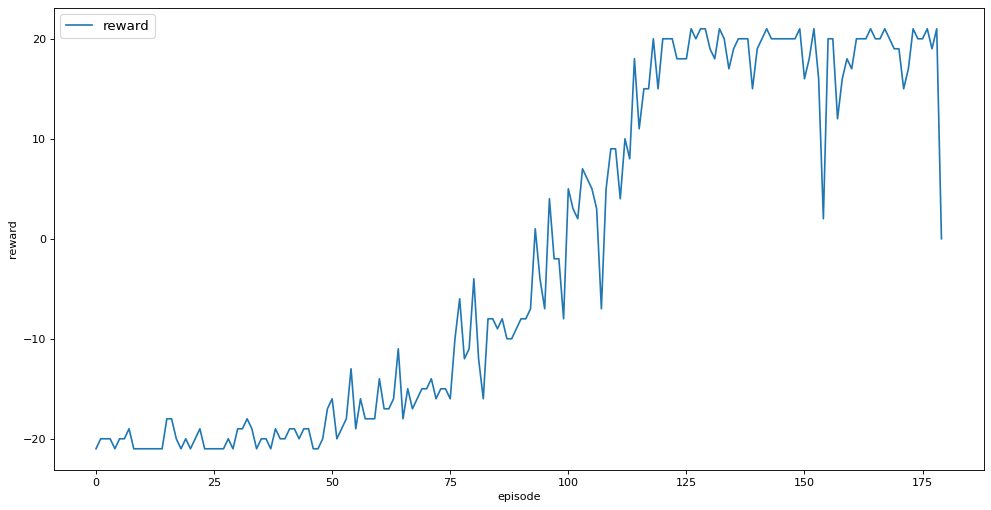

In [ ]:
fig, ax = rl_util.init_2d_figure("Reward")
rl_util.plot_graph(
    ax,
    episode_rewards,
    title="reward",
    ylabel="reward",
    save_dir_name=save_dir,
    is_save=True,
)
rl_util.show_figure()
# fig, ax = rl_util.init_2d_figure("Loss")
# rl_util.plot_graph(
#     ax, losses, title="loss", ylabel="loss", save_dir_name=save_dir, is_save=True
# )
# rl_util.show_figure()

In [ ]:
save_model_name

'result/DDQN/atari/PongNoFrameskip-v4_mean_score.pt'

In [ ]:
env = gym.make(env_name, render_mode="human")
env = gym.wrappers.AtariPreprocessing(env=env, terminal_on_life_loss=True, grayscale_obs=True,
                                            noop_max=0)
# env = ImageToPyTorch(env)
env = gym.wrappers.FrameStack(env, num_stack=4)

test_agent = DQNAgent(
    obs_space_shape=env.observation_space.shape,
    action_space_dims=env.action_space.n,
    is_atari=True,
    config=config
)

# file_name = save_dir + "CartPole-v1_mean_score.pt"
test_agent.policy_network.load_state_dict(torch.load(save_model_name))

for i_episode in range(1):
    state, _ = env.reset()
    test_reward = 0
    while True:
        env.render()
        action = test_agent.select_action(state, 0.)
        next_state, reward, terminated, truncated, _ = env.step(action)
        test_reward += reward
        state = next_state
        done = terminated or truncated
        if done:
            break
    print(f"{i_episode} episode Total Reward: {test_reward}")
env.close()

Model Initializing... An input shape is (4, 84, 84)
Model Initializing... An input shape is (4, 84, 84)
Double DQN Agent


/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:357: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


: 

: 